<a href="https://colab.research.google.com/github/allispaul/audiobot/blob/main/AG_Audiobots_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Audiobots

We're using data from [this dataset](hhttps://huggingface.co/datasets/lewtun/music_genres_small) to try and classify one thousand 30s samples of audio into one of 10 genres:

*   International        
*   Pop                  
*   Electronic           
*   Chiptune / Glitch    
*   Punk                 
*   Folk                 
*   Hip-Hop              
*   Rock                 
*   Instrumental         
*   Experimental

The data is a .parquet file containing ~30s (uncompressed?) .wav files (I have to check bit depths and sample rates still), along with song_id (does this mean anything to anyone?), and the genre from one of the 10 categories above.

We are assuming the genres are accurate. Notably, the ``International'' genre appears to contain a variety of other genres of music, and many songs can come from more than one genre. We may eliminate this class if it causes problems.

For training, we will feed the 90\% of the data into a pre-trained Transformer network from HuggingSpace, and fine-tune the network to classify one of the 10 genres above. If the architecture requries inputs of constant size, we can either pad shorter samples with 0's, or randomly clip shorter sections of longer audio streams.

This code does the following:

*   Downloads the data from Google Drive
*   (TODO) Splits the data into a CONSISTENT training and validation set. No need to create a test set until we get to the larger datasets.
*   Calculates statistics for each class, verifying the same number of tracks in each genre, and that the size of each song is similar.
*   (TODO) Determine if there's a way to analyze the average value/volume for each track.
*   (TODO) Do we want to normalize the data in any way? I suspect Electronic music will be consistently louder than Folk music, which could throw off a (dumb) model just by changing the volume.
*   (TODO) Create a simple model to predict genre from the data
*   (TODO) Turn the data into spectrograms. This should probably be done once and saved instead of on the fly, as different settings could produce drastically different pictures.

In [11]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
!pip install datasets[audio]

In [25]:
from datasets import load_dataset, Audio

In [14]:
music_small = load_dataset("lewtun/music_genres_small",split="train")

In [26]:
music_small_resampled = music_small.cast_column("audio", Audio(sampling_rate=44_100))

In [29]:
music_small_resampled[23], music_small[23]

({'audio': {'path': None,
   'array': array([-0.23038176, -0.26832825, -0.26040655, ...,  0.12153471,
           0.11241338,  0.10263588]),
   'sampling_rate': 44100},
  'song_id': 14909,
  'genre_id': 6,
  'genre': 'Chiptune / Glitch'},
 {'audio': {'path': None,
   'array': array([-0.254604  , -0.26018386, -0.26634176, ...,  0.1270264 ,
           0.10603907,  0.10632006]),
   'sampling_rate': 48000},
  'song_id': 14909,
  'genre_id': 6,
  'genre': 'Chiptune / Glitch'})

Dataset loads as a dictionary of dictionaries, including audio path = None for all, array, sampling_rate.

array is the decoded audio data, represented as 1D array.

Sampling rate - the number of samples per second used to represent the audio. 44,100 hertz for the first song. This audio is sampled 44,100 times per second. These are CD quality audio files. If we are thinking about using a pre-tuned model, its sampling rate should be 44,100 hertz.

In [5]:
len(music_small), music_small[0]

(1000,
 {'audio': {'path': None,
   'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00328412,
          -0.00250573, -0.00360047]),
   'sampling_rate': 44100},
  'song_id': 11483,
  'genre_id': 9,
  'genre': 'International'})

Remove columns that are not useful.

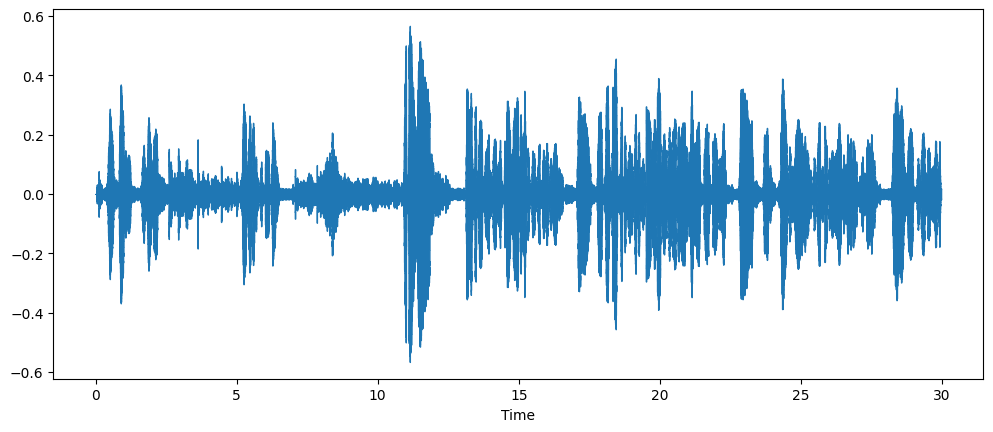

In [37]:
# Plot of an audio file with 44,100 Hz sampling rate
example = music_small[0]
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

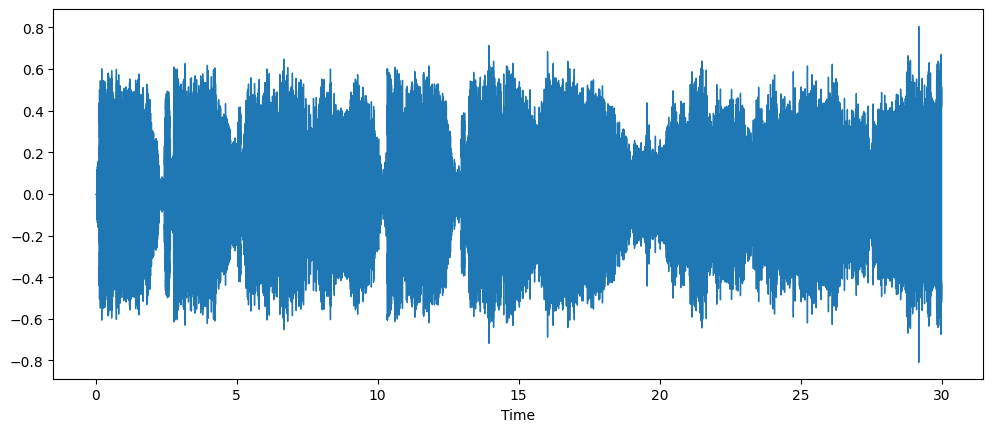

In [44]:
# Plot of an audio file with
example = music_small[34]
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

In [ ]:
music_small

In [10]:
len(music_small[35]["audio"]["array"])

1323119

Do all files have the same sampling rate?

In [15]:
sampling_rate = [sample["audio"]["sampling_rate"] for sample in music_small]

In [16]:
filtered_sampling_rate = [rate for rate in sampling_rate if rate!= 44100] # sampling rates

filtered_sampling_rate_index =[index for index, rate in enumerate(sampling_rate) if rate != 44100]
print(f"The number of audio files that do not match the 44,100 sampling rate is {len(filtered_sampling_rate)}")

filtered_sampling_rate_index

The number of audio files that do not match the 44,100 sampling rate is 57


[23,
 34,
 93,
 100,
 116,
 128,
 142,
 214,
 247,
 280,
 292,
 301,
 313,
 323,
 340,
 348,
 349,
 364,
 393,
 397,
 406,
 411,
 434,
 465,
 474,
 479,
 523,
 526,
 579,
 589,
 594,
 599,
 610,
 617,
 643,
 655,
 661,
 670,
 675,
 679,
 702,
 710,
 721,
 738,
 746,
 759,
 765,
 799,
 801,
 816,
 836,
 853,
 870,
 886,
 928,
 948,
 968]

In [17]:
music_small[23]

{'audio': {'path': None,
  'array': array([-0.254604  , -0.26018386, -0.26634176, ...,  0.1270264 ,
          0.10603907,  0.10632006]),
  'sampling_rate': 48000},
 'song_id': 14909,
 'genre_id': 6,
 'genre': 'Chiptune / Glitch'}

Download the dataset into data folder

In [17]:
!mkdir -p content/data && wget -O content/data/audiodata.parquet "https://huggingface.co/datasets/lewtun/music_genres_small/resolve/main/data/train-00000-of-00001-63d68663287b1638.parquet?download=true"

--2024-03-01 20:19:26--  https://huggingface.co/datasets/lewtun/music_genres_small/resolve/main/data/train-00000-of-00001-63d68663287b1638.parquet?download=true
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.118, 18.164.174.23, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/7d/36/7d36780ef7f5dbd22e4ae2ff5028f5101c93ca9b418b3b0aa84d838dd7d393fb/bed1e08f92cfef798398a7183a23da725ccbf503bc91f45a865749511218f035?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27train-00000-of-00001-63d68663287b1638.parquet%3B+filename%3D%22train-00000-of-00001-63d68663287b1638.parquet%22%3B&Expires=1709583566&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwOTU4MzU2Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83ZC8zNi83ZDM2NzgwZWY3ZjVkYmQyMmU0YWUyZmY1MDI4ZjUxMDFjOTNjYTliN

In [18]:
audio_file = "content/data/audiodata.parquet"
df = pq.read_table(audio_file).to_pandas()
df.head()

,audio,song_id,genre_id,genre
0,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,11483,9,International
1,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,6824,9,International
2,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,8361,8,Pop
3,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,12269,9,International
4,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,1063,0,Electronic


Audio column contains a dictionary. Create a new column called bytes and drop audio (Path is None for all observations).

In [19]:
df["bytes"] = df["audio"].map(lambda d: d["bytes"])

df.drop("audio",axis=1,inplace=True)

Each genre has 100 observations. Most of these have sampling rate of 44,100 Hz. In total, 57 audio files have different than 44,100 Hz. The genre distribution is below:

In [24]:
df.genre.value_counts()

International        100
Pop                  100
Electronic           100
Chiptune / Glitch    100
Punk                 100
Folk                 100
Hip-Hop              100
Rock                 100
Instrumental         100
Experimental         100
Name: genre, dtype: int64

In [23]:
df_nonsample = df.iloc[filtered_sampling_rate_index,]

df_nonsample.genre.value_counts()

Instrumental         17
Punk                 10
International         6
Hip-Hop               6
Chiptune / Glitch     5
Rock                  4
Pop                   3
Experimental          3
Electronic            2
Folk                  1
Name: genre, dtype: int64

In [23]:
filtered_sampling_rate_index[:5]

[23, 34, 93, 100, 116]

In [29]:
audio_data = df.bytes[93]

with open('output_audio.ogg','wb') as audio_file:
  audio_file.write(audio_data)

In [28]:
df.iloc[93]

song_id                                                  2712
genre_id                                                    9
genre                                           International
bytes       b'OggS\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00...
Name: 93, dtype: object

In [ ]:
df.genre_id.value_counts()

In [ ]:
df.genre.value_counts()

In [ ]:
plt.hist(df.genre_id, bins = 19)

Bytes column represent binary data encoded as a byte string. The prefix b shows that it is a byte string, a sequence of bytes stored at the lowest level. Audio data is coded as binary data, and then converted into byte strings so that it can be downloaded, transfered etc. Not human-readable.

Byte string is Ogg format - multimedia including audio. Usually with Vorbis or Opus audio codecs - compressed without significant loss of quality.

We can use special programming in Python to analyze the data to extract its features, even change it so that we change the audio.

As seen below, bytes have different lengths, which corresponds to


In [53]:
len(df.bytes[0]), len(df.bytes[1])

(380792, 406313)

If you want to convert byte strings back to audio data, you can write them using .ogg file type with the code below.

In [55]:
#audio_data = df.bytes[0]

#with open('content/output_audio.ogg','wb') as audio_file:
 # audio_file.write(audio_data)

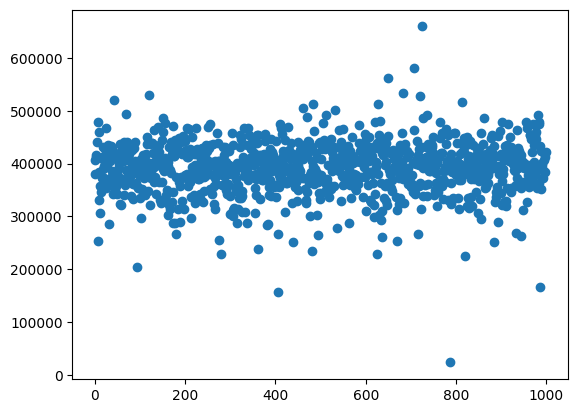

In [ ]:
lengths = []

for sample in df.audio:
    lengths.append(len(sample['bytes']))

plt.scatter(range(1000),lengths)

In [ ]:
print("Longest song (bytes?)", max(lengths))
print("Shortest song (bytes?)", min(lengths))
print("Average song (bytes?)", np.mean(lengths))

Longest song (bytes?) 659948
Shortest song (bytes?) 23181
Average song (bytes?) 391207.36


This could technically be an issue if whatever architecture we're using requires a constant length input.

If so, we could always pad with zeros, or randomly sample 23181 bytes(?) from every longer track.